In [ ]:
!pip install transformers
!pip install xlsxwriter
!pip install ipywidgets
!pip install bertviz

     |████████████████████████████████| 3.5 MB 16.2 MB/s 
     |████████████████████████████████| 596 kB 57.6 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |████████████████████████████████| 6.8 MB 56.6 MB/s 
     |████████████████████████████████| 895 kB 57.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 149 kB 27.8 MB/s 
     |████████████████████████████████| 155 kB 20.3 MB/s 
     |████████████████████████████████| 1.2 MB 53.3 MB/s 
     |████████████████████████████████| 132 kB 64.0 MB/s 
     |████████████████████████████████| 8.5 MB 12.9 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 138 kB 57.0 MB/s 
     |████████████████████████████████| 127 kB 70.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urll

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast,DistilBertForSequenceClassification
from transformers import Trainer,TrainingArguments
from transformers import DistilBertTokenizerFast, BertForMaskedLM
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score
from google.colab import drive
from torch import nn
from transformers import Trainer

# from dataset import load_metric

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import xlsxwriter


import time

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class SarcasimDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
## Test Dataset
class SarcasimTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

In [6]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(labels, pred, average='weighted')

    return {"accuracy": accuracy,"f1_score":f1, "recall": recall, 'precision': precision}

In [7]:
from random import sample, random, shuffle
from math import ceil
import json

class TextMutant():
    def __init__(self):
        synm_filepath = '/content/drive/MyDrive/DataLab/sarcasm/crawler/synm3.json'

        with open(synm_filepath) as json_file:
            self.synoynms = json.load(json_file)
    
    def remove_words(self, sentence, mode = "k-random", k = 0.1, prob = 0.1):
        word_list = sentence.split()
        new_words = []
        if mode == "prob":
            for i in word_list:
                if (random() < prob):
                    continue
                new_words.append(i)
        if mode == "k-random":
            num = round(len(word_list) * k)
            random_index = sample(list(range(len(word_list))), num)
            new_words = list( word_list[i] for i in range(len(word_list)) if i not in random_index )
        return " ".join(new_words)

    def shuffle_words(self, sentence, prob = 0.1):
        word_list = sentence.split()
        indexes = list(range(len(word_list)))
        if (random() < prob):
            shuffle(indexes)
        new_words = list( word_list[i] for i in indexes )
        return " ".join(new_words)
    
    def replace_words(self, sentence, mode = "k-random", k = 0.1, prob = 0.1):
        word_list = sentence.split()
        new_words = []
        if mode == "prob":
            for i in word_list:
                self.synoynms.setdefault(i, [])
                if (random() < prob and len(self.synoynms[i]) > 0):
                    new_words.append(sample(self.synoynms[i], 1)[0])
                    continue
                new_words.append(i)
        if mode == "k-random":
            num = round(len(word_list) * k)
            indexes = list(range(len(word_list)))
            shuffle(indexes)
            new_words = word_list[:]
            for i in indexes:
                self.synoynms.setdefault(word_list[i], [])
                if (num > 0 and len(self.synoynms[word_list[i]]) > 0):
                    new_words[i] = sample(self.synoynms[word_list[i]], 1)[0]
                    num -= 1
        return " ".join(new_words)

    def create_new_sentence(self, sentence, flags,  shuffle_prob = 1, replace_k = 0.5, remove_k = 0.3):
      if flags[0] == '1':
        sentence = self.remove_words(sentence, k = remove_k)
      if flags[1] == '1':
        sentence = self.replace_words(sentence, k = replace_k)
      if flags[2] == '1':
        sentence = self.shuffle_words(sentence, prob=shuffle_prob)
      return sentence
    
    def create_new_dataset(self, dataset, flags):
      dataset_copy = dataset.copy()
      for i in range(len(dataset['tweet'])):
        dataset_copy['tweet'].iloc[i] = self.create_new_sentence(dataset_copy['tweet'].iloc[i], flags)
      return dataset_copy

In [8]:
mutator = TextMutant()

In [73]:
#test
dataset_test = pd.read_csv('/content/drive/MyDrive/DataLab/sarcasm/FinalDataset/task_A_En_test.csv')
print(len(dataset_test))

1400


In [72]:
df = pd.read_csv('/content/drive/MyDrive/DataLab/sarcasm/FinalDataset/train.En.csv')[['tweet', 'sarcastic']]
df = df.dropna(subset=['tweet'])
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df2 = pd.read_csv('/content/drive/MyDrive/DataLab/sarcasm/FinalDataset/data4.csv')[['tweet', 'sarcastic']]
# df2 = df2.rename(columns={"label":"sarcastic"})
df2 = df2.dropna(subset=['tweet'])
# df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)

df = pd.concat([df, df2]).reset_index(drop=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,tweet,sarcastic
0,It was the,1
1,Their website doesn't seem to mention Axa nor ...,0
2,Imagine not liking football 🤣,1
3,play golf is just class watch,0
4,I want one of those insects. You know,0
...,...,...
6929,@DanielIngolfur @The_Timbrodini @ViQueen55 @te...,1
6930,Every once in a I forget that Tatiana Maslany ...,0
6931,Was fun. forward to the next #podcasts,0
6932,i think it should be illegal for the my window...,0


In [11]:
# X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['sarcastic'], test_size=0.1, random_state=42)

In [12]:
# mutated = mutator.create_new_dataset(pd.DataFrame(X_train), '111')

In [13]:
# X_train = pd.concat([X_train, mutated['tweet']], axis=0)
# y_train = pd.concat([y_train, y_train], axis=0)

In [14]:
X_train = df['tweet']
y_train = df['sarcastic']
X_test = dataset_test['text']
y_test = dataset_test['sarcastic']

In [15]:
print(len(X_train))
print(len(y_train))

6934
6934


In [16]:
X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

In [71]:
from transformers import AutoModel
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification

# model
model_name = 'detecting-sarcasim'
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL,num_labels=2, loss_function_params={"weight": [0.75, 0.25]})
# model
model = AutoModel.from_pretrained(MODEL)

# tokenize
train_encodings = tokenizer(X_train, truncation=True, padding=True,return_tensors = 'pt')
# test_encodings = tokenizer(X_test,truncation=True, padding=True,return_tensors = 'pt')

# change to dataset
train_dataset = SarcasimDataset(train_encodings, y_train)
# test_dataset = SarcasimDataset(test_encodings, y_test)

# trainer args
training_args = TrainingArguments(
  output_dir='./res', num_train_epochs=5, per_device_train_batch_size=32, warmup_steps=500, weight_decay=0.01,logging_dir='./logs4'
  )



# model.save_pretrained(MODEL)




Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

In [74]:
sent_id = tokenizer.batch_encode_plus(X_train, padding=True)

In [75]:
print(sent_id)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



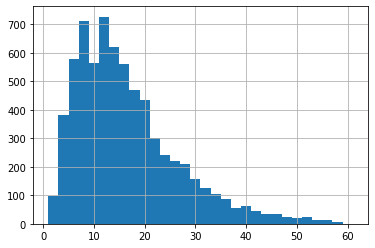

In [76]:
seq_len = [len(i.split()) for i in X_train]
pd.Series(seq_len).hist(bins = 30)

In [77]:
tokens_train = tokenizer.batch_encode_plus(
    X_train,
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)
train_seq = torch.tensor(tokens_train['input_ids'])

In [78]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train)

In [79]:
tokens_test = tokenizer.batch_encode_plus(
    X_test,
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [80]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test)

In [81]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


In [82]:
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
test_data = TensorDataset(test_seq, test_mask, test_y)
batch_size = 32
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [83]:
for param in model.parameters():
    param.requires_grad = False

In [84]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      # _, cls_hs = self.bert(sent_id, attention_mask=mask)
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [85]:
model = BERT_Arch(model)

# push the model to GPU
# device = torch.device("cuda")
# model = model.to(device)

from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5) 

In [86]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(df['sarcastic']),
                                        y = df['sarcastic']                                                    
                                    )

print("Class Weights:",class_weights)

Class Weights: [0.66673077 1.9994233 ]


In [87]:
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
# weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

In [88]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    # batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        
    # print('here')
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()
    
    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [89]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    # batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [90]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    217.
  Batch   100  of    217.
  Batch   150  of    217.
  Batch   200  of    217.

Evaluating...

Training Loss: 0.691
Validation Loss: 0.684

 Epoch 2 / 5
  Batch    50  of    217.
  Batch   100  of    217.
  Batch   150  of    217.
  Batch   200  of    217.

Evaluating...

Training Loss: 0.685
Validation Loss: 0.679

 Epoch 3 / 5
  Batch    50  of    217.
  Batch   100  of    217.
  Batch   150  of    217.
  Batch   200  of    217.

Evaluating...

Training Loss: 0.681
Validation Loss: 0.681

 Epoch 4 / 5
  Batch    50  of    217.
  Batch   100  of    217.
  Batch   150  of    217.
  Batch   200  of    217.

Evaluating...

Training Loss: 0.678
Validation Loss: 0.666

 Epoch 5 / 5
  Batch    50  of    217.
  Batch   100  of    217.
  Batch   150  of    217.
  Batch   200  of    217.

Evaluating...

Training Loss: 0.675
Validation Loss: 0.669


In [91]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [96]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq, test_mask)
  # preds = preds.detach().cpu().numpy()
  preds = preds.detach().numpy()

In [97]:
from sklearn.metrics import classification_report

# temp = test_y.reshape(1400,1)
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.89      0.69      0.78      1200
           1       0.21      0.49      0.30       200

    accuracy                           0.66      1400
   macro avg       0.55      0.59      0.54      1400
weighted avg       0.79      0.66      0.71      1400



In [103]:
# f1_score(test_y,preds, average='macro')
f1_score(test_y,preds)

0.29596412556053814

In [95]:
f = open('/content/drive/MyDrive/DataLab/sarcasm/FinalDataset/result/attention-rs-roberta', 'w')


for pred in preds:
  f.write(str(pred) + "\n")

f.close()